# Galaxy Zoo CNN

Julian Avila

Camilo Huertas

In [5]:
from google.colab import drive
import os
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Javascript, display, Markdown, clear_output

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


!pip install Augmentor
import Augmentor


import pickle

# Convenient Pickle wrappers
def save(obj, file):
    pickle.dump(obj, open(SAVE + file ,'wb')) # SAVE is global variable for directory

def load(file):
    return pickle.load(open(SAVE + file, 'rb'))

def RMSE(pred, truth):
    # Element-wise RMSE score.
    return np.sqrt( np.mean( np.square( np.array(pred).flatten() - np.array(truth).flatten() )))

RANDOM = 42
random.seed(RANDOM)

display(Markdown("# Markdown is working"))

# Markdown is working

In [6]:
%%capture

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

drive.mount('/content/gdrive')
!pip install kaggle
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/"

# The data is directories of jpg images. A lot of them.
DATA = "/content/images_training_rev1/"
!mkdir /content/processed_64x64
!mkdir /content/processed_128x128
DIR_64 = '/content/processed_64x64/'
DIR_128 = '/content/processed_128x128/'
!mkdir /content/processed_64x64_WIDE
!mkdir /content/processed_128x128_WIDE
DIR_64_WIDE = '/content/processed_64x64_WIDE/'
DIR_128_WIDE = '/content/processed_128x128_WIDE/'



# Directory for saving models
SAVE = "/content/gdrive/My Drive/kaggle/GalaxyZoo/"
FIGS = "/content/gdrive/My Drive/kaggle/GalaxyZoo/figs/"


In [7]:
# Unpack training and validation datasets
!unzip /content/galaxy-zoo-the-galaxy-challenge.zip
!rm /content/galaxy-zoo-the-galaxy-challenge.zip
!unzip /content/images_training_rev1.zip
!unzip /content/training_solutions_rev1.zip



Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: images_training_rev1/926446.jpg  
  inflating: images_training_rev1/926448.jpg  
  inflating: images_training_rev1/926453.jpg  
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflating: images_training_rev1/926655.jpg  
  inflating: images_training_rev1/926657.jpg  
  inflating: images_training_rev1/926675

In [8]:
images = [f for f in os.listdir(DATA) if os.path.isfile(os.path.join(DATA, f))]
print("There are " + '{:,}'.format(len(images)) + " images in the dataset.")
labels = pd.read_csv('training_solutions_rev1.csv')
labels.GalaxyID = labels.GalaxyID.apply(lambda id: str(int(id)) + '.jpg')
save(labels, 'labels.p')
print("There are " + '{:,}'.format(labels.shape[0]) + " truth values.")
print("There are " + '{:,}'.format(labels.shape[1]-1) + " categories for classification.")
desc = ['Smooth','Featured or disc','Star or artifact','Edge on','Not edge on','Bar through center','No bar','Spiral','No Spiral','No bulge','Just noticeable bulge','Obvious bulge','Dominant bulge','Odd Feature','No Odd Feature','Completely round','In between','Cigar shaped','Ring (Oddity)','Lens or arc (Oddity)','Disturbed (Oddity)','Irregular (Oddity)','Other (Oddity)','Merger (Oddity)','Dust lane (Oddity)','Rounded bulge','Boxy bulge','No bulge','Tightly wound arms','Medium wound arms','Loose wound arms','1 Spiral Arm','2 Spiral Arms','3 Spiral Arms','4 Spiral Arms','More than four Spiral Arms',"Can't tell"]


There are 61,578 images in the dataset.
There are 61,578 truth values.
There are 37 categories for classification.


In [9]:
def average_color(pic):
    '''
    pic is a 4 dimensional array where d0 is the index, d1 and d2 are the
    x and y values of the image and d3 is the values of the pixels (R,G,B
    in this dataset but it will scale to anything).

    I'm taking the mean value of pixels in each image by summing across
    d1 and d2 then dividing by the total number of pixels.
    '''
    return np.sum(pic, axis=(1,2)) / (pic.shape[1] * pic.shape[2])


def center_pixel(pic):
    return pic[:,int(pic.shape[1] / 2),int(pic.shape[2] / 2),:]


def image_generator(pics, path=DATA, batch_size=30, rotate=False, size=100, save=False,
                    retrieve=False):
    '''
    Generate batches of numpy arrays from a list of image filenames.
    DATA is a global variable with the path to the image folder.

    Output array has 4 dimensions in this order:
        - Index of pictures in this batch
        - x dimension of pixels in individual image
        - y dimension of pixels in individual image
        - Color depth (R,G,B in this project, but it can scale)
    '''
    l = len(pics)
    batches = int(l/batch_size)
    leftover = l % batch_size
    for batch in range(batches):
        start = batch * batch_size
        this_batch = pics[start:start+batch_size]
        if rotate:
            yield np.array([
                            scipy.misc.imresize(
                                scipy.ndimage.rotate(
                                plt.imread(path + pic, format='jpg'),
                                reshape=False,
                                angle=random.randint(0,360, random_seed=RANDOM)
                                ),
                                size=size
                            )

                            for pic in this_batch])
        else:
            yield np.array([ plt.imread(path + pic, format='jpg') for pic in this_batch])
    start = batches * batch_size
    this_batch = pics[start:start+leftover]
    yield np.array([ plt.imread(path + pic, format='jpg') for pic in this_batch])


In [10]:
X, X_val, y, y_val = train_test_split(labels.GalaxyID,
                                labels[labels.columns[1:]],
                                test_size = 0.20,
                                random_state = RANDOM
                                )
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = RANDOM
                                                    )

print("Training set: %d" % X_train.shape[0])
print("Testing set: %d" % X_test.shape[0])
print("Validation set: %d" % X_val.shape[0])

Training set: 39409
Testing set: 9853
Validation set: 12316


In [11]:
i = 0
for image in labels.GalaxyID:
    i += 1
    if i > 10000:
      continue

    im = cv2.imread(DATA + image)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # I read the docs and found this uses human perception of luminance already.
    ret, thresh = cv2.threshold(im, 25, 255, 0)
    # The numbers are upper and lower thresholds
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    ROI = (0,0,0,0) # Region of interest
    ROI_area = 0
    for contour in contours: # cv.RETR_LIST exports contrours as a list.
        x, y, width, height = cv2.boundingRect(contour)
        area = width * height
        if area > ROI_area:
            ROI_area = area
            ROI = (x,y,width,height)

    x, y, width, height = ROI

    if width > height:
        crop = im[y:y+width,x:x+width]
    else:
        crop = im[y:y+height,x:x+height]

    image = image.replace('jpg','png') # I don't want to multiple the compression loss. meme.jpg.jpg.jpg

    # 64x64
    cv2.imwrite(
        DIR_64 + image, # OpenCV adheres to file extension formats
        cv2.resize(crop, (64,64), interpolation=cv2.INTER_AREA)
    )


!zip -r -j '/content/64.zip' '/content/processed_64x64/'
!cp '64.zip' '/content/gdrive/My Drive/kaggle/GalaxyZoo/'
!zip -r -j '/content/128.zip' '/content/processed_128x128/'
!cp '128.zip' '/content/gdrive/My Drive/kaggle/GalaxyZoo/'

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: 196512.png (stored 0%)
  adding: 166600.png (stored 0%)
  adding: 209493.png (stored 0%)
  adding: 202424.png (stored 0%)
  adding: 176068.png (stored 0%)
  adding: 123192.png (stored 0%)
  adding: 190319.png (stored 0%)
  adding: 228042.png (stored 0%)
  adding: 241372.png (stored 0%)
  adding: 179786.png (stored 0%)
  adding: 207405.png (stored 0%)
  adding: 219528.png (stored 0%)
  adding: 143193.png (stored 0%)
  adding: 124977.png (stored 0%)
  adding: 232059.png (stored 0%)
  adding: 169755.png (stored 0%)
  adding: 176873.png (stored 0%)
  adding: 157818.png (stored 0%)
  adding: 186771.png (stored 0%)
  adding: 120648.png (stored 0%)
  adding: 165193.png (stored 0%)
  adding: 191775.png (stored 0%)
  adding: 215204.png (stored 0%)
  adding: 163047.png (stored 0%)
  adding: 130574.png (stored 0%)
  adding: 139375.png (stored 0%)
  adding: 156615.png (stored 0%)
  adding: 113512.png (stored 0%)
  adding:

In [12]:
padding_size = 0.2

i = 0
for image in labels.GalaxyID:
    i += 1

    im = cv2.imread(DATA + image)
    im2 = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # I read the docs and found this uses human perception of luminance already.
    ret, thresh = cv2.threshold(im2, 10, 255, 0)
    # The numbers are upper and lower thresholds
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    ROI = (0,0,0,0) # Region of interest
    ROI_area = 0
    for contour in contours: # cv.RETR_LIST exports contrours as a list.
        x, y, width, height = cv2.boundingRect(contour)
        area = width * height
        if area > ROI_area:
            ROI_area = area
            ROI = (x,y,width,height)

    x, y, width, height = ROI

    if width > height:
        pad = int(width * padding_size)
    else:
        pad = int(height * padding_size)

    if (y-pad >= 0 and
        x-pad >= 0 and
        y + max(width, height) + pad < im.shape[1] and
        x + max(width, height) + pad < im.shape[0]):

        crop = im[y-pad:y+max(width,height)+pad,x-pad:x+max(width,height)+pad]
    else:
        crop = im

    image = image.replace('jpg','png') # I don't want to multiple the compression loss. meme.jpg.jpg.jpg


    # 64x64
    cv2.imwrite(

        DIR_64_WIDE + image, # OpenCV adheres to file extension formats
        cv2.resize(crop, (64,64), interpolation=cv2.INTER_AREA)
    )

    if i > 10000:
      continue

!zip -r -j '/content/64_WIDE.zip' '/content/processed_64x64_WIDE/'
!cp '64_WIDE.zip' '/content/gdrive/My Drive/kaggle/GalaxyZoo/'
!zip -r -j '/content/128_WIDE.zip' '/content/processed_128x128_WIDE/'
!cp '128_WIDE.zip' '/content/gdrive/My Drive/kaggle/GalaxyZoo/'

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: 385807.png (deflated 1%)
  adding: 658740.png (deflated 2%)
  adding: 621443.png (deflated 2%)
  adding: 795985.png (deflated 0%)
  adding: 957266.png (deflated 1%)
  adding: 452981.png (deflated 1%)
  adding: 599255.png (deflated 0%)
  adding: 119009.png (deflated 1%)
  adding: 439865.png (deflated 1%)
  adding: 805869.png (deflated 2%)
  adding: 191160.png (deflated 2%)
  adding: 728524.png (deflated 0%)
  adding: 209575.png (deflated 1%)
  adding: 747312.png (deflated 0%)
  adding: 750105.png (deflated 1%)
  adding: 282107.png (deflated 1%)
  adding: 983592.png (deflated 1%)
  adding: 477385.png (deflated 2%)
  adding: 427520.png (deflated 2%)
  adding: 249504.png (deflated 2%)
  adding: 292022.png (deflated 1%)
  adding: 634336.png (deflated 1%)
  adding: 503606.png (deflated 1%)
  adding: 991150.png (deflated 2%)
  adding: 599927.png (deflated 1%)
  adding: 193247.png (deflated 2%)
  adding: 137783.png (d

In [13]:
def torch_batches(pics, labels, path=DATA, batch_size=30, rotate=False, fmt='png'):
    '''
    Generate batches of PyTorch tensors from a list of image filenames.
    DATA is a global variable with the path to the image folder.
    '''
    angles = np.array([0,90,180,270])
    labels = torch.tensor(labels, dtype=torch.float32)
    l = len(pics)
    batches = int(l/batch_size)
    leftover = l % batch_size
    for batch in range(batches):
        start = batch * batch_size
        this_batch = pics[start:start+batch_size]
        batch_labels = labels[start:start+batch_size,:]

        if rotate:
            yield torch.tensor([scipy.ndimage.rotate(
                                plt.imread(path + pic, format=fmt),
                                reshape=False,
                                angle=np.random.randint(0,360)
                                )
                            for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch
        else:
            yield torch.tensor([ plt.imread(path + pic, format=fmt) for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch
    start = batches * batch_size
    this_batch = pics[start:start+leftover]
    batch_labels = labels[start:start+leftover,:]
    if rotate:
        yield torch.tensor([scipy.ndimage.rotate(
                            plt.imread(path + pic, format=fmt),
                            reshape=False,
                            angle=np.random.randint(0,360)
                            )
                        for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch

    yield torch.tensor([ plt.imread(path + pic, format=fmt) for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch



In [14]:
def get_output_width(width, kernel, padding, stride):
    return int((width + 2 * padding - kernel - 1) / stride + 1)

In [22]:
'''
Attempt 1:

With 64x64 grayscale input achieved an RMSE of 0.17497 in 180 epochs.
Very bad results, there's a problem with the model.
'''

classes = labels.columns[1:]

in_width = 64

kernel = 3
pool_kernel = 2
padding = int(kernel/2)
stride = 1

c1_in = 3
c1_out = 8
c1_pooled_width = get_output_width(in_width, pool_kernel, padding, pool_kernel)

c2_out = 16
c2_pooled_width = get_output_width(c1_pooled_width, pool_kernel, padding, pool_kernel)

full_1_in = c2_out * c2_pooled_width * c2_pooled_width
full_1_out = int(full_1_in / 8)
full_2_out = int(full_1_out/4)
full_3_out = len(classes)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        These are the layers in the network, and their attributes are the
        weights and biases of the neurons.
        '''
        self.conv1 = nn.Conv2d(in_channels=c1_in,
                               out_channels=c1_out,
                               kernel_size=kernel,
                               stride=stride,
                               padding=padding,
                               padding_mode='zeros') # convolution layer, padding with zeros is convenient because the image background is black
        self.pool = nn.MaxPool2d(2) # 2x2 kernel, stride of 2 so there's no overlap, and it's a max pooling strategy
        self.conv2 = nn.Conv2d(in_channels=c1_out,
                               out_channels=c2_out,
                               kernel_size=kernel,
                               stride=stride,
                               padding=padding,
                               padding_mode='zeros')
        # we can re-use the pooling step if the strategy stays the same
        self.fc1 = nn.Linear(full_1_in, full_1_out)
        self.fc2 = nn.Linear(full_1_out, full_2_out)
        self.fc3 = nn.Linear(full_2_out, full_3_out)
        # self.dropout = nn.Dropout(p=0.1) # http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf

    def forward(self, x):
        # feed each layer into the next
        x = self.pool(F.relu(self.conv1(x))) # first convolution
        x = self.pool(F.relu(self.conv2(x))) # second convolution
        x = x.reshape(x.size()[0],-1) # flatten output for fully connected layer
        x = F.relu(self.fc1(x)) # Linear equation wrapped in activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # The output layer
        return x

net = Net()

In [19]:
labels = load('labels.p')

# I skipped the validation split to get more training data. In the competition,
# the data is validated against a withheld dataset which I do not have.

X_train, X_test, y_train, y_test = train_test_split(labels.GalaxyID.apply(lambda pic: pic.replace('jpg', 'png')),
                                                    labels[labels.columns[1:]].to_numpy(),
                                                    test_size = 0.20,
                                                    random_state = RANDOM
                                                    )

print("Training set: %d" % X_train.shape[0])
print("Testing set: %d" % X_test.shape[0])
# print("Validation set: %d" % X_val.shape[0])

def RMSE(pred, truth):
    # Element-wise RMSE score.
    return np.sqrt( np.mean( np.square( np.array(pred).flatten() - np.array(truth).flatten() )))

Training set: 49262
Testing set: 12316


In [23]:
loss_weight = torch.tensor(np.sum(y_train, axis=0) / np.sum(y_train))

def weighted_mse_loss(output, targets, weights):
    loss = (output - targets) ** 2
    loss = loss * weights.expand(loss.shape) # broadcast (37,) weight array to (n, 37).
    loss = loss.mean(0)
    return loss.sum()

# optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.7)
optimizer = optim.Adam(net.parameters()) # Adam should converge faster than stochastic gradient descent

loss_history = []
batch_size = 1024
mini_batch_size = 64
display("Start")

for epoch in range(1,6):
    batch_no = 1

    datagen = torch_batches(X_train,
                        y_train,
                        path=DIR_64_WIDE,
                        batch_size=batch_size,
                        rotate=True)

    for images, targets, _ in datagen: # big read from storage
        for mini_batch in range(int(batch_size/mini_batch_size)):
            start = mini_batch*mini_batch_size
            if start >= images.shape[0]:
                break
            finish = start + mini_batch_size
            optimizer.zero_grad()
            outputs = net(images[start:finish])
            loss = weighted_mse_loss(outputs, targets[start:finish], loss_weight)
            loss.backward()
            optimizer.step()
        clear_output()
        display("Epoch %d, batch %d - loss: %.5f" % (epoch, batch_no, loss.item()))
        batch_no += 1
        loss_history.append((epoch, batch_no, loss.item()))

save(net, 'net_4.p')
torch.save(net, 'net_t_4.p')
save(optimizer, 'optim_4.p')

'Epoch 5, batch 50 - loss: 0.02957'

In [24]:
datagen = torch_batches(X_test,
                    y_test,
                    path=DIR_64_WIDE,
                    batch_size=1000)

pred = np.empty((0,len(classes)), float)

for images, targets, pics in datagen:
    outputs = net(images)
    pred = np.append(pred, outputs.detach().numpy(), axis=0)

RMSE(y_test, pred)

np.float64(0.12891644377399966)

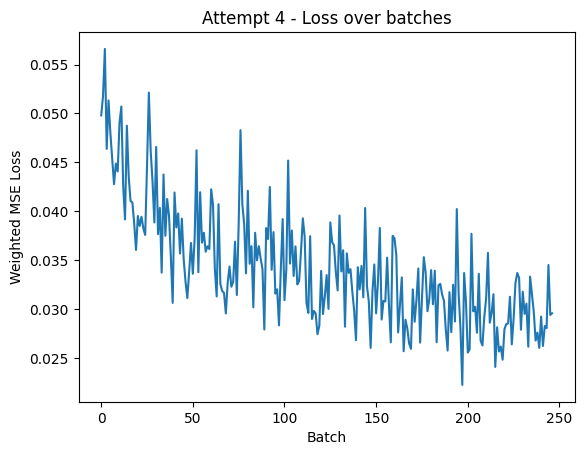

In [25]:
import matplotlib.pyplot as plt
title = "Attempt 4 - Loss over batches"
plt.title(title)
plt.xlabel('Batch')
plt.ylabel('Weighted MSE Loss')
plt.plot([error[2] for error in loss_history[3:]])
plt.savefig(FIGS + title +'.png')
plt.show()